## Introduction

Applying for a loan can be a tiring, extensive process: many variables can affect one's loan approval status, and it is hard to determine which one is more significant for a successful application. With this in mind, this project will aim to answer the question **“Is it possible to determine loan approval status based on household income (co-applicant and applicant income), loan term, and loan amount?”.**

**TODO:** add more stuff to intro, perhaps how getting rejected for a loan can affect credit score and make it harder to get loans in the future, which is why being able to tell whether you will be approved is important

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows
set.seed(2024)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### 1. Demonstration that the data set `loan_data.csv` can be read into R

In [2]:
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

head(loan_data)

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
LP001013,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1,Urban,Y
LP001024,Male,Yes,2,Graduate,No,3200,700,70,360,1,Urban,Y


### 2. Data wrangling and cleaning

The data needs to be cleaned and wrangled into an appropriate format before we begin analysis. The following steps were done to prepare the data:

1. **The column `Loan_Status` is not stored as a categorical variable like it should be:** use the `mutate` and `as_factor` functions to do this conversion.
2. **There is no variable for the total income amount of the applicant's household:** use the `mutate` function to create a new column named `TotalIncome` using the `ApplicantIncome` and `CoapplicantIncome` columns
3. **There are rows with missing values:** use the `drop_na()` function to drop rows containing missing values.
4. **Some of the column names are not standardized. Some spaces are separated with underscores, such as `Self_Employed`, some with capital letters, such as `LoanAmount`:** standardize the column names by assigning the new column names to a vector and passing it to the `colnames` function. 

In [3]:
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

loan_data <- loan_data |> 
    mutate(Loan_Status = as_factor(Loan_Status)) |>
    mutate(TotalIncome = ApplicantIncome + CoapplicantIncome) |>
    drop_na() |>
    select(-Loan_ID, -Gender, -Married, -Property_Area)

# Standardising column names
colnames(loan_data) <- c("Dependents", "Education", "SelfEmployed", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanTerm", "CreditHistory", "LoanStatus", "TotalIncome")

head(loan_data)

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Graduate,No,4583,1508,128,360,1,N,6091
0,Graduate,Yes,3000,0,66,360,1,Y,3000
0,Not Graduate,No,2583,2358,120,360,1,Y,4941
0,Graduate,No,6000,0,141,360,1,Y,6000
0,Not Graduate,No,2333,1516,95,360,1,Y,3849
2,Graduate,No,3200,700,70,360,1,Y,3900


As seen in the table above, there is significantly (~48%) more positive classes (LoanStatus == Y) than negative classes. This class imbalance could lead to worse performance in our classifier. Hence, there is a need to balance these classes by 

### 3. Split, train and test of data set loan_data

In [4]:
loan_split <- initial_split(loan_data, prop = 0.75, strata = LoanStatus)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

nrow(loan_train)
nrow(loan_test)

[1] 230

[1] 78

### 4. Preliminary summary table of data

In [5]:
loan_train_summary <- loan_train |>
    group_by(LoanStatus) |>
    summarize(Count = n(), MeanApplicantIncome = mean(ApplicantIncome), MeanCoapplicantIncome = mean(CoapplicantIncome), MeanLoanAmount = mean(LoanAmount), MeanLoanTerm = mean(LoanTerm))

loan_train_summary

LoanStatus,Count,MeanApplicantIncome,MeanCoapplicantIncome,MeanLoanAmount,MeanLoanTerm
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
N,66,3417.439,1437.970,100.1667,345.0909
Y,164,3638.348,1215.457,104.1646,340.7561


### 5. Preliminary visualization of data

#### 5.1. Distribution of key predictors

**Predictor Distributions:** It is necessary to visualize the distribution of the predictors (`ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, and `LoanTerm`) to gather more information on the data set and better understand the implications of their usage in the knn algorithm. To do so, it is necessary to create 5 histograms: `income_dist_plot`, `coincome_dist_plot`, `loan_amount_plot`, `loan_term_plot`, and `loan_combined_plot`.

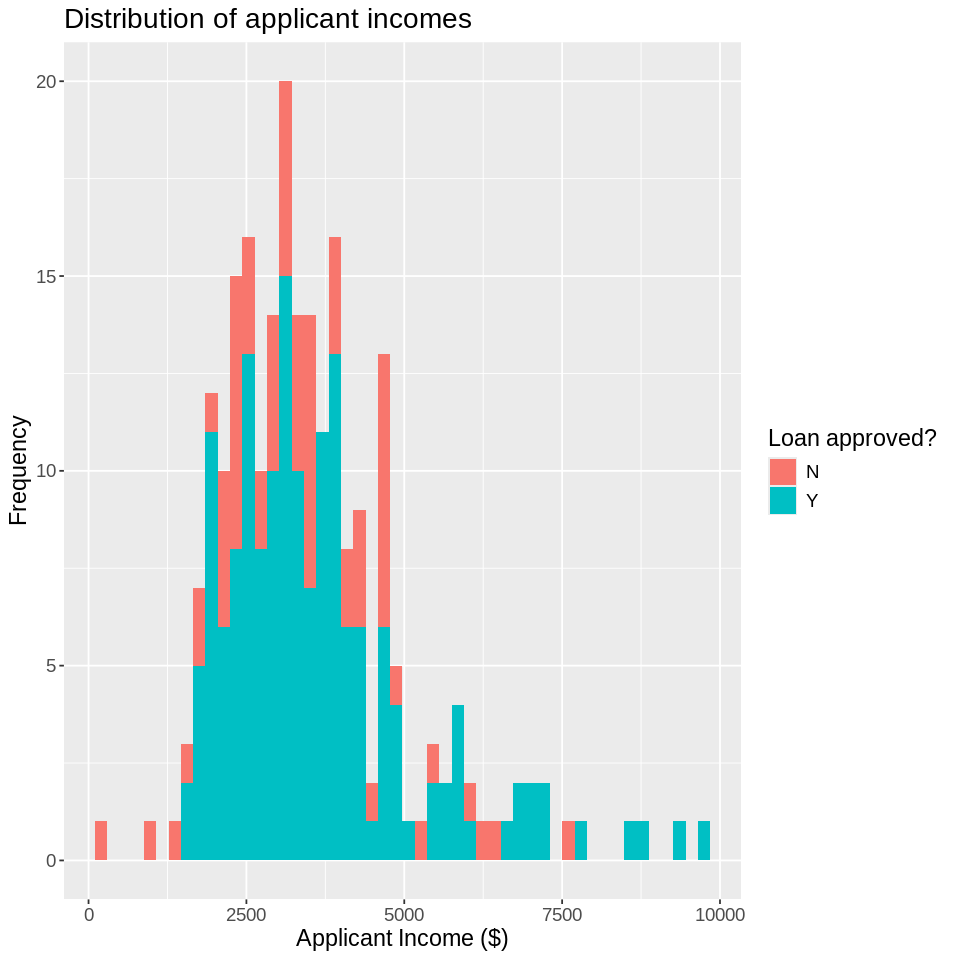

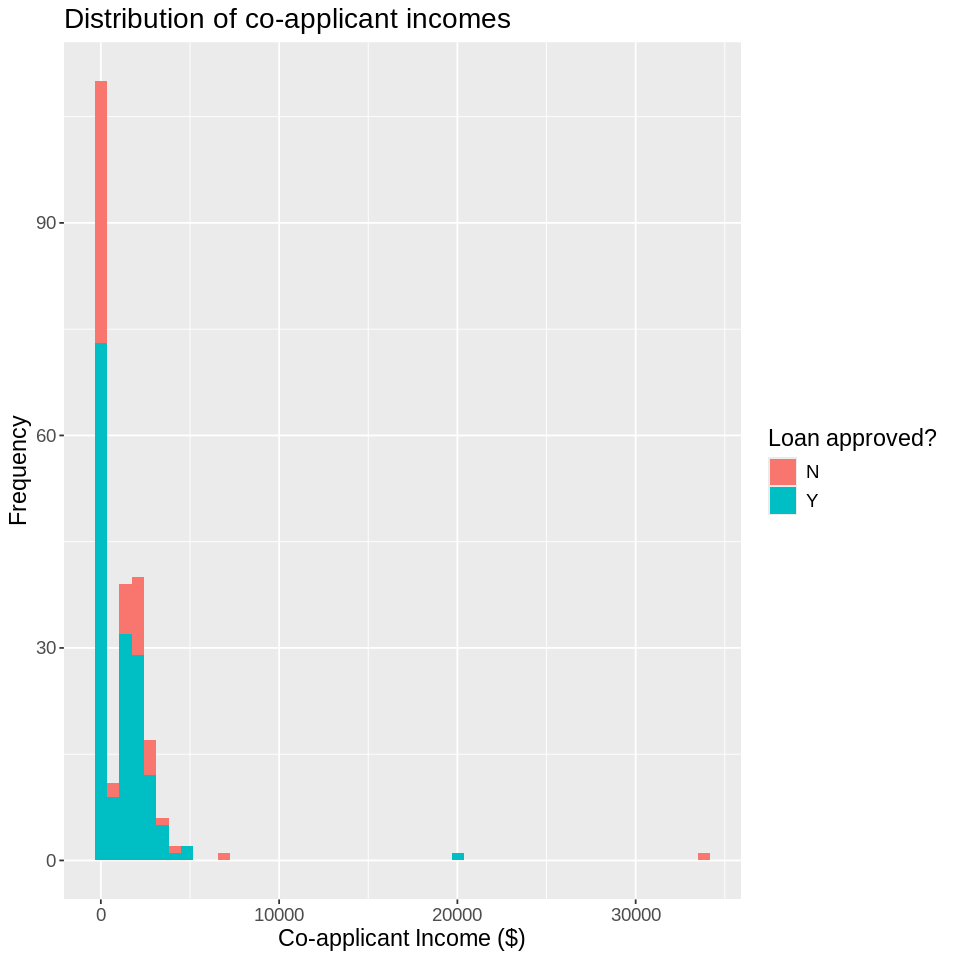

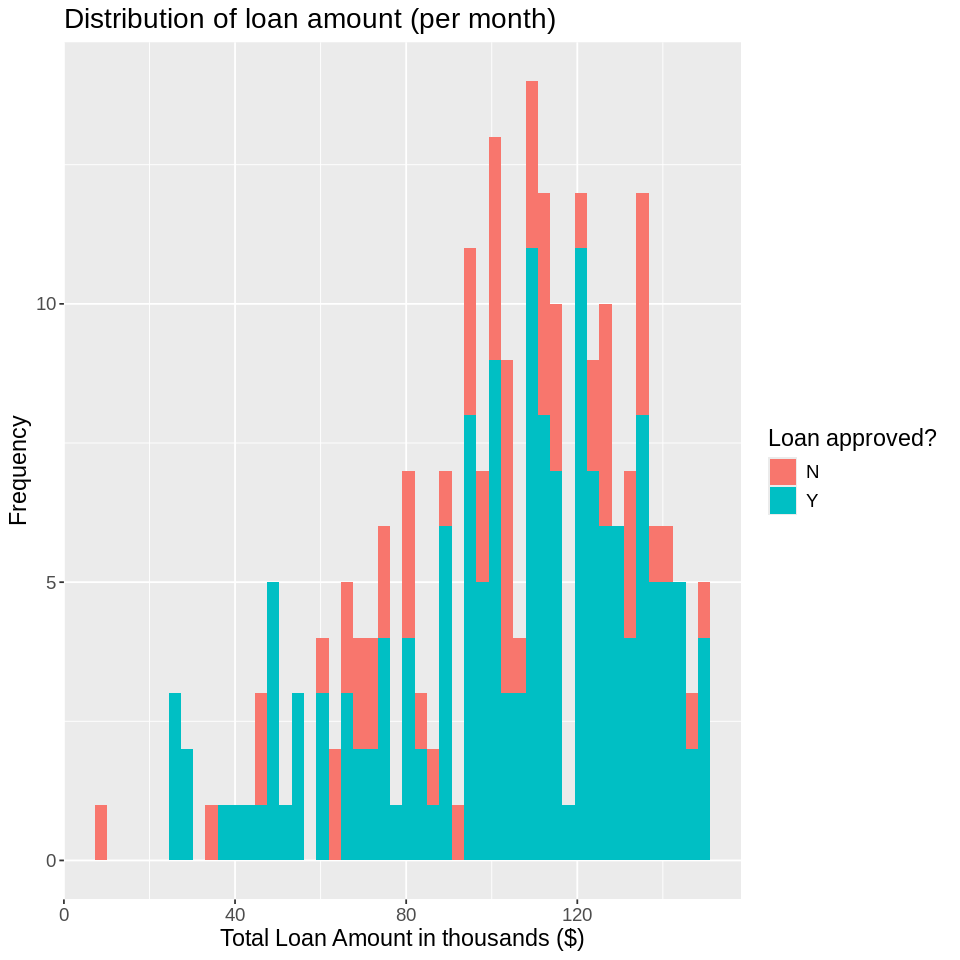

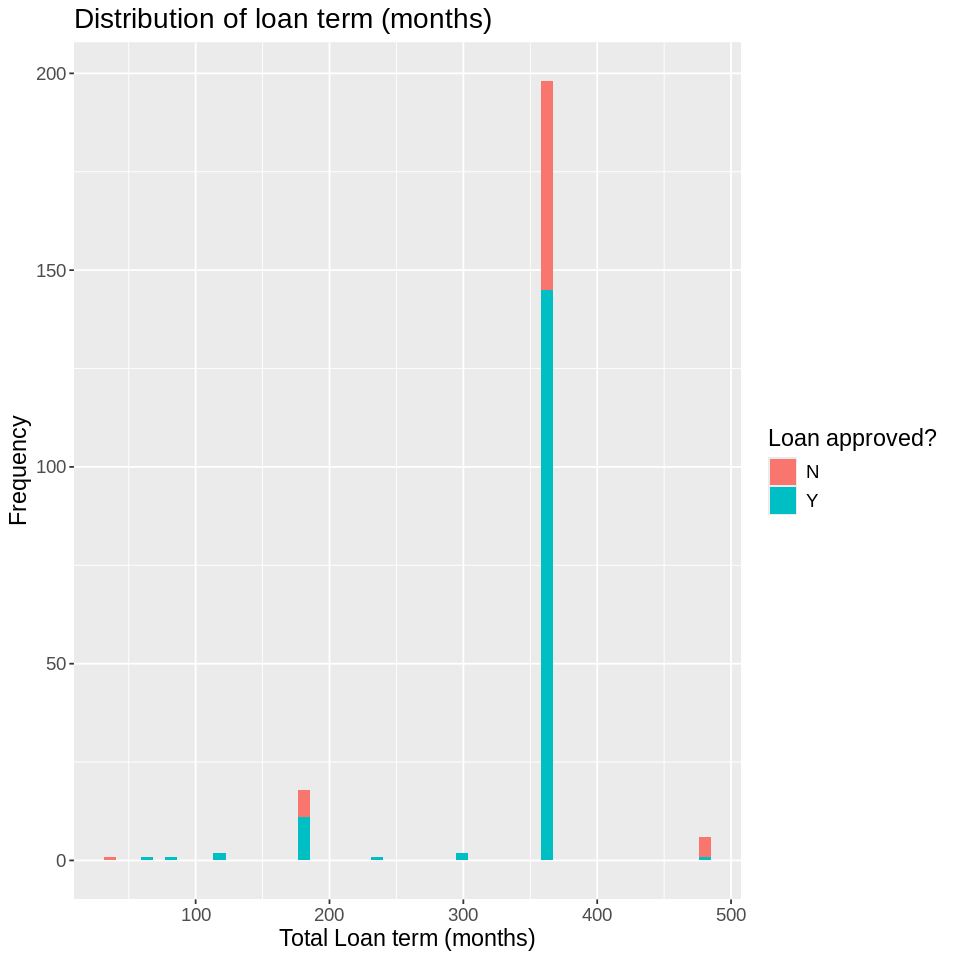

In [6]:
options(repr.plot.width=8, repr.plot.height=8)

income_dist_plot <- loan_train |>
    ggplot(aes(x=ApplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of applicant incomes", x = "Applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
income_dist_plot

coincome_dist_plot <- loan_train |>
    ggplot(aes(x=CoapplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of co-applicant incomes", x = "Co-applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
coincome_dist_plot

loan_amount_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan amount (per month)", x = "Total Loan Amount in thousands ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_amount_plot

loan_term_plot <- loan_train |>
    ggplot(aes(x=LoanTerm, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan term (months)", x = "Total Loan term (months)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_term_plot

#### 5.2. Relationship between Income and Loan Amount

**Relationship Analysis:** To prepare for the KNN classification, it is necessary to explore the relationship between predictor variables and the response variable. The scatter plot `relationship_plot` should better demonstrate the relationship between `TotalIncome`, `TotalLoanAmount` and `LoanStatus`.

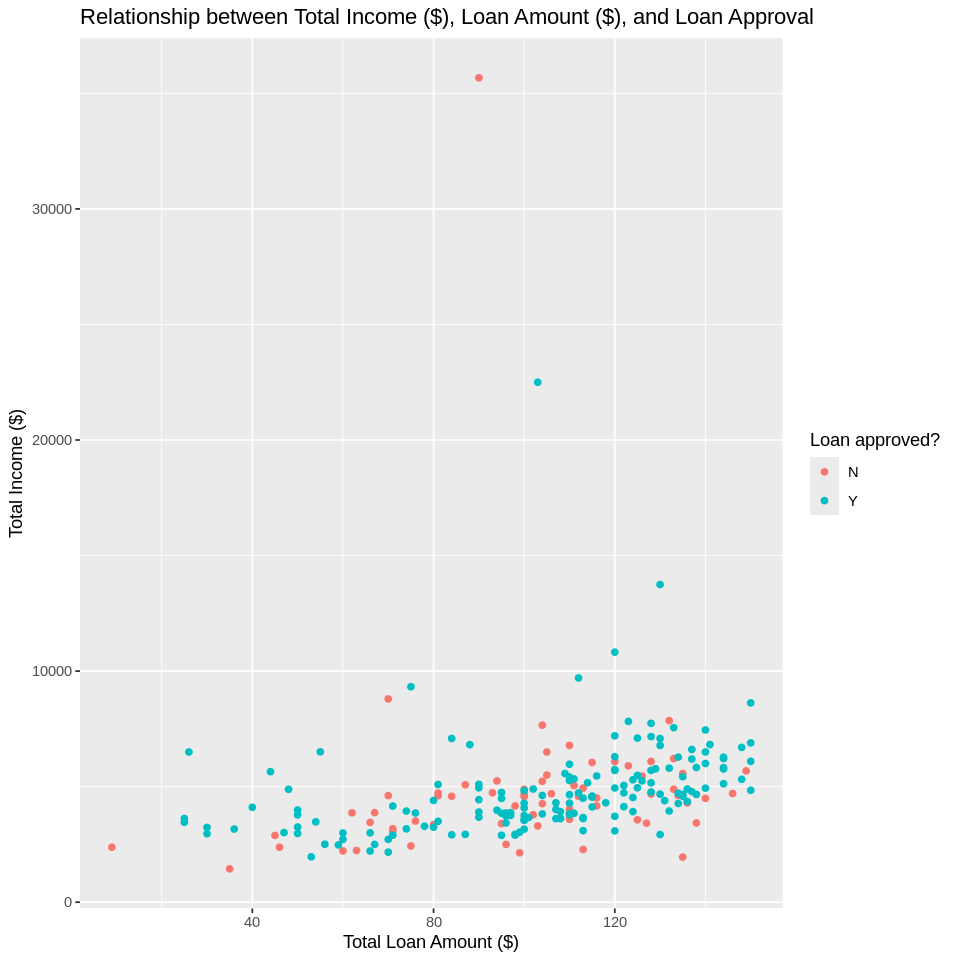

In [7]:
relationship_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, y=TotalIncome, color=LoanStatus)) +
    geom_point() + 
    labs(title = "Relationship between Total Income ($), Loan Amount ($), and Loan Approval", x="Total Loan Amount ($)", y="Total Income ($)", color="Loan approved?")
relationship_plot

## Methods

 This project aims to use the following variables as predictors:
 - `ApplicantIncome`: Monthly income in dollars for the main applicant
 - `CoapplicantIncome`: Monthly income in dollars for any co-applicants in the main applicant's household
 - `LoanAmount`: Loan amount in thousands of dollars
 - `LoanTerm`: Loan term in months

In the preliminary data analysis, the data summary includes the number of occurrences for each class, and the mean values of the predictors intended to be used.

**(1)** There are almost twice as many positive `LoanStatus` class occurrences as negative ones. This will lead to a class imbalance that affects the classifier's performance. To solve this, either an upsample of the negative classes or a downsample of the positive classes will be necessary.

**(2)** The predictors intended to be used have largely the same mean values for both the positive and negative classes. This could be due to large variance or outliers within the predictors affecting the mean.

The visualizations created involve the distributions of the predictors intended to be used. From the visualizations, it is possible to see that there are some class imbalances for outlier values, especially in `Applicant/co-applicantIncome` and the `LoanTerm`. This could lead to poor classification for new observations near the outlier values and may need to be removed.

Other visualizations involving scatter plots of the relationships between predictors will be necessary. This will allow for determining if there is any clear grouping occurring, and to potentially determine which predictors are the most important in the classifier.

## 6. Creating the model

To create our model, we will do the following steps:

1. Create a recipe that predicts ```LoanStatus```, with ```ApplicantIncome, CoapplicantIncome, LoanAmount, LoanTerm``` as predictors.
2. Create a specification that uses k-nearest neighbors, with neighbors = tune() to select the best ```K``` value.
3. Split the data into 10 folds to perform cross-validation.
4. Create a workflow to train the classifier with ```tune_grid()```.

### 6.1. Dealing with class imbalance

As seen in the summary table earlier, the positive class (LoanStatus == Y) appears significantly (~48%) more than the negative class. This imbalance could lead to poor performance of the classifier. When building our model, we will upsample the negative class by using ```step_upsample()``` as part of the recipe. It is important to set ```skip = TRUE``` to ensure that the upsampling is done only on the training data.

We also center and scale the predictors to ensure they have equal impact on the classifier.

In [14]:
loan_recipe <- recipe(LoanStatus ~ ApplicantIncome + CoapplicantIncome + LoanAmount +  LoanTerm + CreditHistory, data = loan_train) |>
    step_upsample(LoanStatus, skip = TRUE) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

### 6.2 Training the model

In [21]:
# K-nearest neighbour model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Perform 10 fold-cross valdiation
loan_vfold <- vfold_cv(loan_train, v = 10, strata = LoanStatus)

# K value in range [0, 50]
gridvals <- tibble(neighbors = c(1:50))

# Create workflow
knn_results <- workflow() |>
      add_recipe(loan_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = loan_vfold, grid = gridvals) |>
# Collect metrics, filter for accuracy
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))

head(knn_results)

neighbors,mean
<int>,<dbl>
29,0.8163538
30,0.8163538
15,0.8125659
16,0.8125659
23,0.8124012
24,0.8124012


### Choosing a ```K``` value

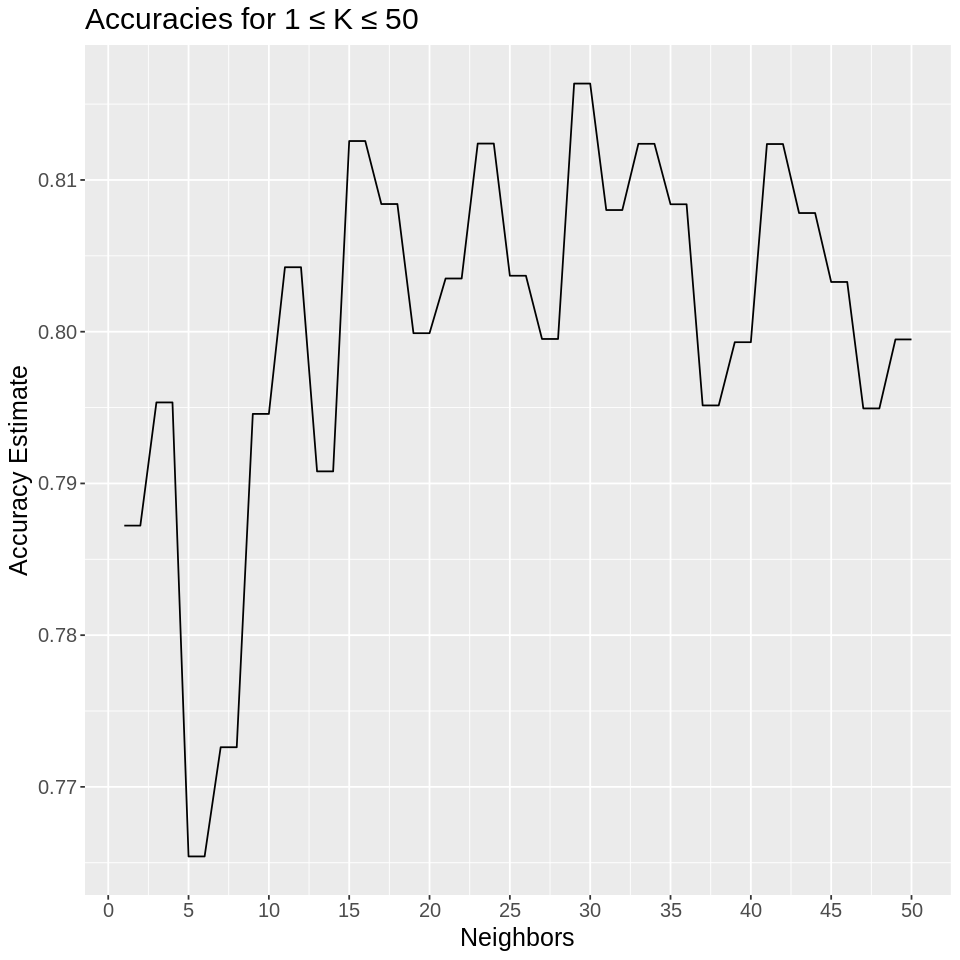

In [25]:
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ K ≤ 50") +
      scale_x_continuous(breaks = seq(0, 50, by = 5)) + # adjusting the x-axis
      theme(text = element_text(size = 15))

accuracy_versus_k

### 6.4 Building the final model

In [28]:
final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 29) |>
    set_engine("kknn") |>
    set_mode("classification")

loan_fit <- workflow() |>
    add_recipe(loan_recipe) |>
    add_model(final_spec) |>
    fit(data = loan_train)

### 6.5 Testing the final model

In [29]:
predictions <- predict(loan_fit, loan_test) %>%
               bind_cols(loan_test)

metrics <- predictions |>
    metrics(truth = LoanStatus, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat <- predictions |>
    conf_mat(truth = LoanStatus, estimate = .pred_class)
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8076923


          Truth
Prediction  N  Y
         N 13  5
         Y 10 50